In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/high_diamond_ranked_10min.csv
/content/.config/gce
/content/.config/active_config
/content/.config/config_sentinel
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/.metricsUUID
/content/.config/configurations/config_default
/content/.config/logs/2020.12.02/22.03.37.873126.log
/content/.config/logs/2020.12.02/22.04.38.150307.log
/content/.config/logs/2020.12.02/22.04.21.823807.log
/content/.config/logs/2020.12.02/22.04.13.854338.log
/content/.config/logs/2020.12.02/22.03.59.234441.log
/content/.config/logs/2020.12.02/22.04.37.441505.log
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv


In [ ]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data
Data I will be using for this project is "high_diamond_ranked_10min.csv"
from https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

It contains columns of "blueWins" which is my target variable, and other variables such as "blueKills" or "blueTotalGold", and I will be trying to figure out what components are most important in winning a game of league during first 10 minutes of the game.
Also, I will be comparing accuracy of following algorithms. 
["Logistic Regression", "Decision Tree Classification", "XGBoost", "Neural Network (Keras)", "Neural Network (Pytorch)"]

In [ ]:
# import data
url = '/content/high_diamond_ranked_10min.csv'

data = pd.read_csv(url, index_col=0)
data.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
gameId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [ ]:
# data types are mostly int64, and some are float64
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9879 entries, 4519157822 to 4523772935
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueEliteMonsters             9879 non-null   int64  
 8   blueDragons                   9879 non-null   int64  
 9   blueHeralds                   9879 non-null   int64  
 10  blueTowersDestroyed           9879 non-null   int64  
 11  blueTotalGold                 9879 non-null   int64  
 12  blueAvgLevel                  9879 non-null   f

In [ ]:
# no NULL values exist in the dataset
data.isna().values.any()

False

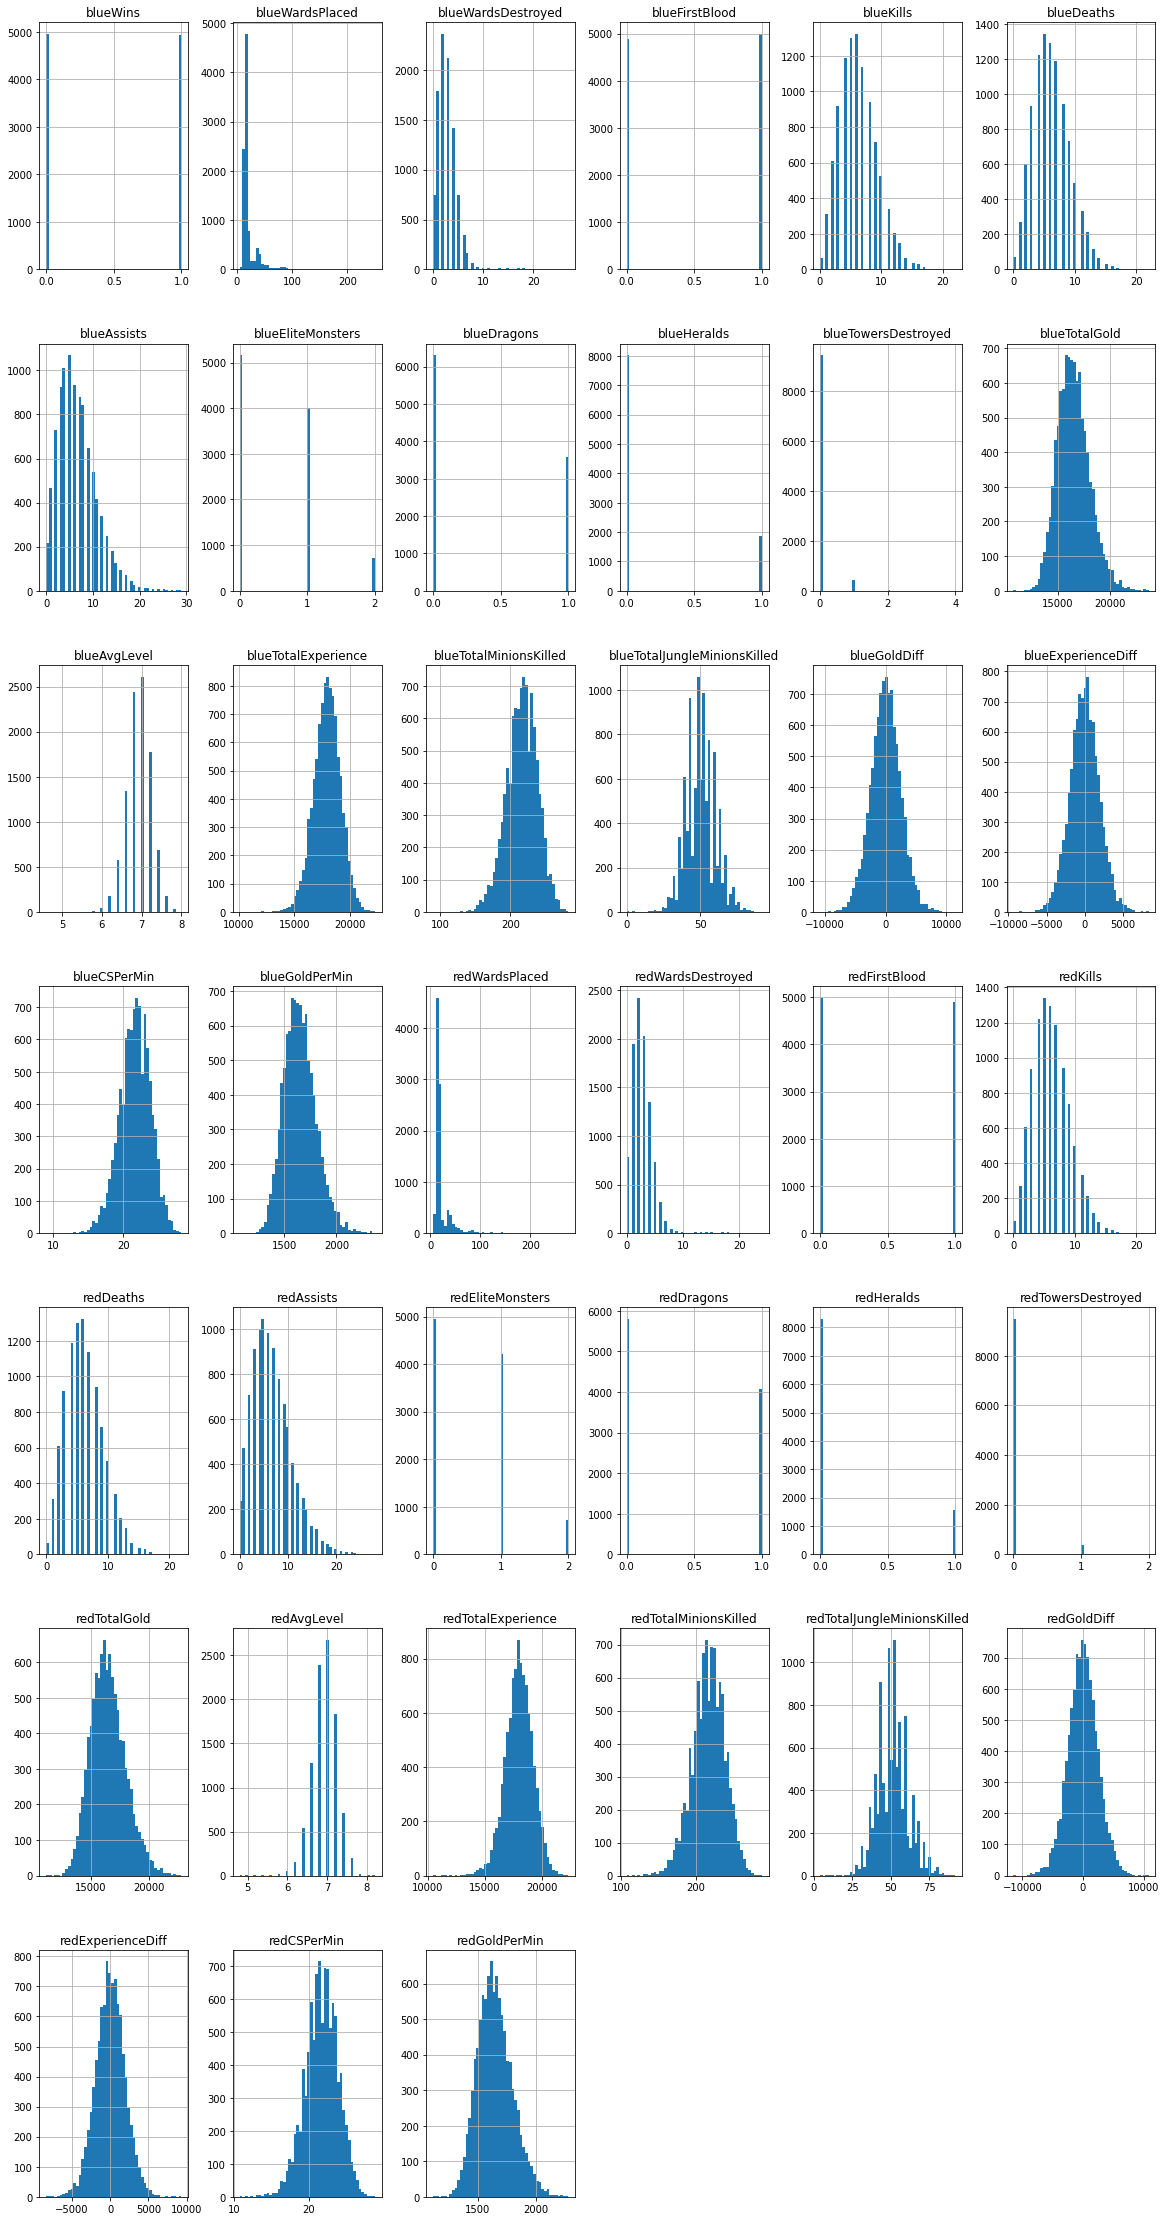

In [ ]:
# Check histogram to see if data is normally distributed.
data.hist(bins = 50, figsize = (20,40))
plt.show()

Most of data is normally distributed so now I'm ready to pre process the data.

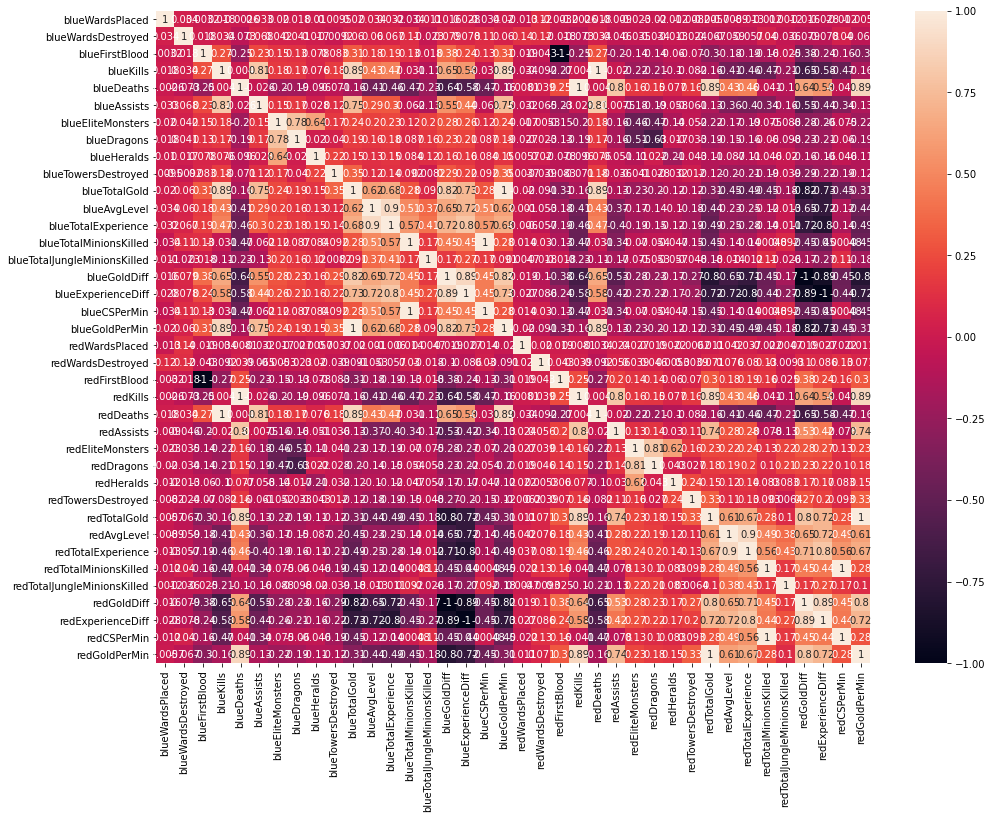

In [ ]:
# check heatmap for correlations
import seaborn as sns
plt.figure(figsize=(16, 12))
temp = data.copy()
sns.heatmap(temp.drop('blueWins', axis=1).corr(), annot=True);

In [ ]:
# find highly correlated values with correlation over 0.9
corr = pd.DataFrame(temp.corr().unstack().sort_values().drop_duplicates())
corr.columns = ['cr']
corr[(corr['cr'] > 0.9) | (corr['cr'] < -0.9)]


,,cr
blueExperienceDiff,redExperienceDiff,-1.000000
blueTotalExperience,blueAvgLevel,0.901297
redAvgLevel,redTotalExperience,0.901748
redCSPerMin,redCSPerMin,1.000000
blueTotalGold,blueGoldPerMin,1.000000
blueTotalMinionsKilled,blueCSPerMin,1.000000
redCSPerMin,redTotalMinionsKilled,1.000000
redTotalGold,redGoldPerMin,1.000000


# Preparing Data

In [ ]:
# Drop highly correlated values and reformat data.
df = data.copy()

df['ExperienceDiff'] = df['blueExperienceDiff']
df['blueWardScore'] = df['blueWardsPlaced'] + df['blueWardsDestroyed']
df['redWardScore'] = df['redWardsPlaced'] + df['redWardsDestroyed']

df = df.drop(columns=['blueWardsPlaced', 'blueWardsDestroyed', 'redWardsPlaced', 'redWardsDestroyed'])
df = df.drop(columns=['blueExperienceDiff', 'redExperienceDiff', 'blueTotalMinionsKilled', 'redTotalMinionsKilled', 'blueGoldPerMin','redGoldPerMin', 'blueAvgLevel','redAvgLevel'])
df = df.drop(columns=['blueFirstBlood', 'redFirstBlood'])
df.head()

,blueWins,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueCSPerMin,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redTotalExperience,redTotalJungleMinionsKilled,redGoldDiff,redCSPerMin,ExperienceDiff,blueWardScore,redWardScore
gameId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4519157822,0,9,6,11,0,0,0,0,17210,17039,36,643,19.5,6,9,8,0,0,0,0,16567,17047,55,-643,19.7,-8,30,21
4523371949,0,5,5,5,0,0,0,0,14712,16265,43,-2908,17.4,5,5,2,2,1,1,1,17620,17438,52,2908,24.0,-1173,13,13
4521474530,0,7,11,4,1,1,0,0,16113,16221,46,-1172,18.6,11,7,14,0,0,0,0,17285,17254,28,1172,20.3,-1033,15,18
4524384067,0,4,5,5,1,0,1,0,15157,17954,55,-1321,20.1,5,4,10,0,0,0,0,16478,17961,47,1321,23.5,-7,44,17
4436033771,0,6,6,6,0,0,0,0,16400,18543,57,-1004,21.0,6,6,7,1,1,0,0,17404,18313,67,1004,22.5,230,79,19


# Machine Learning Algorithms

In [ ]:
# create trainset and test set
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

# X is variables, y is the target "blueWins"
X = df.drop('blueWins', axis = 1)
y = df['blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_scaled = preprocessing.scale(X_train)

## Logistic Regression

In [ ]:
# train
from sklearn.linear_model import LogisticRegression
Logreg = LogisticRegression(random_state = 1)
scores = cross_val_score(Logreg, X_scaled, y_train, scoring = 'accuracy', cv = 10)
meanScore = scores.mean()

print("Logistic Regression model has Accuracy of", meanScore)

Logistic Regression model has Accuracy of 0.7316215653955097


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(max_depth = 2, random_state = 3)

scores = cross_val_score(decisionTree, X_scaled, y_train, scoring = 'accuracy', cv = 10)
meanScore = scores.mean()
print("Decision Tree model has Accuracy of", meanScore)

Decision Tree model has Accuracy of 0.7258005408951976


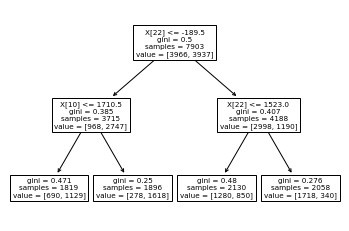

In [ ]:
#  plot decision tree
from sklearn import tree
decisionTree.fit(X_train, y_train)
decisionTree.predict(X_test)
tree.plot_tree(decisionTree);

## XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators = 100 ,learning_rate = 0.1)

scores = cross_val_score(xgb, X_scaled, y_train, scoring = 'accuracy', cv = 10)
meanScore = scores.mean()
print("XGBoost model has Accuracy of", meanScore)

XGBoost model has Accuracy of 0.728458448686969


[0] blueKills has feature importance of 0.023184478282928467
[1] blueDeaths has feature importance of 0.024283558130264282
[2] blueAssists has feature importance of 0.016227567568421364
[3] blueEliteMonsters has feature importance of 0.030031917616724968
[4] blueDragons has feature importance of 0.036023467779159546
[5] blueHeralds has feature importance of 0.006249427329748869
[6] blueTowersDestroyed has feature importance of 0.0
[7] blueTotalGold has feature importance of 0.024360589683055878
[8] blueTotalExperience has feature importance of 0.02345031499862671
[9] blueTotalJungleMinionsKilled has feature importance of 0.02545071765780449
[10] blueGoldDiff has feature importance of 0.40110206604003906
[11] blueCSPerMin has feature importance of 0.01830883137881756
[12] redKills has feature importance of 0.0
[13] redDeaths has feature importance of 0.0
[14] redAssists has feature importance of 0.023921972140669823
[15] redEliteMonsters has feature importance of 0.038663946092128754
[1

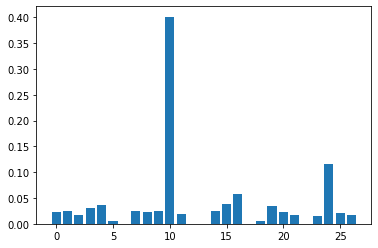

In [ ]:
# Displaying Feature Importance
from matplotlib import pyplot

xgb.fit(X_train, y_train)

fi = xgb.feature_importances_
pyplot.bar(range(len(fi)), fi)
for i, item in enumerate(X_train.columns.values):
  print(f'[{i}] {item} has feature importance of {fi[i]}')
pyplot.show()

## Neural Network (Keras)

In [ ]:
# import libraries
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow import keras
from keras.models import Model   

In [ ]:
k_df = df;
y=data['blueWins'] 
k_df.drop(['blueWins'],1,inplace=True)
k_df

,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueCSPerMin,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redTotalExperience,redTotalJungleMinionsKilled,redGoldDiff,redCSPerMin,ExperienceDiff,blueWardScore,redWardScore
gameId,,,,,,,,,,,,,,,,,,,,,,,,,,,
4519157822,9,6,11,0,0,0,0,17210,17039,36,643,19.5,6,9,8,0,0,0,0,16567,17047,55,-643,19.7,-8,30,21
4523371949,5,5,5,0,0,0,0,14712,16265,43,-2908,17.4,5,5,2,2,1,1,1,17620,17438,52,2908,24.0,-1173,13,13
4521474530,7,11,4,1,1,0,0,16113,16221,46,-1172,18.6,11,7,14,0,0,0,0,17285,17254,28,1172,20.3,-1033,15,18
4524384067,4,5,5,1,0,1,0,15157,17954,55,-1321,20.1,5,4,10,0,0,0,0,16478,17961,47,1321,23.5,-7,44,17
4436033771,6,6,6,0,0,0,0,16400,18543,57,-1004,21.0,6,6,7,1,1,0,0,17404,18313,67,1004,22.5,230,79,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4527873286,7,4,5,1,1,0,0,17765,18967,69,2519,21.1,4,7,7,0,0,0,0,15246,16498,34,-2519,22.9,2469,19,49
4527797466,6,4,8,1,1,0,0,16238,19255,48,782,23.3,4,6,3,0,0,0,0,15456,18367,56,-782,20.6,888,54,33
4527713716,6,7,5,0,0,0,0,15903,18032,45,-2416,21.0,7,6,11,1,1,0,0,18319,19909,60,2416,26.1,-1877,24,14


In [ ]:
# Normalize Z-Score
mean = k_df.mean(axis=0)
std = k_df.std(axis=0)
n_df = (k_df-mean)/std
n_df.head()

,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueCSPerMin,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redTotalExperience,redTotalJungleMinionsKilled,redGoldDiff,redCSPerMin,ExperienceDiff,blueWardScore,redWardScore
gameId,,,,,,,,,,,,,,,,,,,,,,,,,,,
4519157822,0.935254,-0.046924,1.071441,-0.879186,-0.753188,-0.481108,-0.210428,0.460156,-0.740602,-1.465877,0.256215,-0.992732,-0.046924,0.935254,0.329479,-0.914847,-0.838923,-0.436473,-0.198343,0.052290,-0.763176,0.367666,-0.256215,-0.928694,0.013341,0.268151,-0.219682
4523371949,-0.393196,-0.387777,-0.404748,-0.879186,-0.753188,-0.481108,-0.210428,-1.166733,-1.385320,-0.758684,-1.191194,-1.953459,-0.387777,-0.393196,-1.148130,2.277585,1.191884,2.290861,4.412078,0.758580,-0.436958,0.068500,1.191194,1.033731,-0.593312,-0.664675,-0.649261
4521474530,0.271029,1.657340,-0.650779,0.719467,1.327556,-0.481108,-0.210428,-0.254294,-1.421971,-0.455601,-0.483590,-1.404472,1.657340,0.271029,1.807089,-0.914847,-0.838923,-0.436473,-0.198343,0.533882,-0.590472,-2.324826,0.483590,-0.654867,-0.520410,-0.554931,-0.380774
4524384067,-0.725309,-0.387777,-0.404748,0.719467,-0.753188,2.078325,-0.210428,-0.876915,0.021565,0.453648,-0.544323,-0.718238,-0.387777,-0.725309,0.822016,-0.914847,-0.838923,-0.436473,-0.198343,-0.007406,-0.000609,-0.430109,0.544323,0.805542,0.013862,1.036360,-0.434472
4436033771,-0.061084,-0.046924,-0.158716,-0.879186,-0.753188,-0.481108,-0.210428,-0.067378,0.512185,0.655703,-0.415112,-0.306498,-0.046924,-0.061084,0.083211,0.681369,1.191884,-0.436473,-0.198343,0.613700,0.293070,1.564329,0.415112,0.349164,0.137276,2.956883,-0.327077


In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(27,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

opt = optimizers.Adam(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(k_df, y, batch_size=100, epochs=4, validation_split=0.2)

Epoch 1/4
80/80 [==============================] - 0s 3ms/step - loss: 207.7623 - accuracy: 0.6401 - val_loss: 32.0732 - val_accuracy: 0.7212
Epoch 2/4
80/80 [==============================] - 0s 2ms/step - loss: 81.6577 - accuracy: 0.6411 - val_loss: 90.9528 - val_accuracy: 0.6098
Epoch 3/4
80/80 [==============================] - 0s 2ms/step - loss: 54.2966 - accuracy: 0.6429 - val_loss: 108.7775 - val_accuracy: 0.5177
Epoch 4/4
80/80 [==============================] - 0s 2ms/step - loss: 57.8162 - accuracy: 0.6370 - val_loss: 59.9405 - val_accuracy: 0.5061


## Neural Network (Pytorch)

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
# get data
targets = data[['blueWins']].values
features = df.values

test_size = int(.10 * 9879) 
val_size = test_size
train_size = 9879 - test_size*2
train_size , val_size, test_size


dataset = TensorDataset(torch.tensor(features).float(), torch.from_numpy(targets).float())
pt_train, val_df, test_df = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# train
input_size = 27 
output_size = 1 
threshold = 0.5
batch_size = 128

train_loader = DataLoader(pt_train, batch_size, shuffle=True)
val_loader = DataLoader(val_df, batch_size)
test_loader = DataLoader(test_df, batch_size)


In [ ]:
class PTModel(nn.Module):
    def __init__(self):
        # initiate the model
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, xb):
        # forward function of the model 
        out = self.sigmoid(self.linear(xb))
        return out
    
    def training_step(self, batch):
        # used for training per batch in an eopch
        inputs, labels = batch
        out = self(inputs)
        loss = F.binary_cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        # used on function `evaluate` to iterate model through a batch
        inputs, labels = batch
        out = self(inputs)
        loss = F.binary_cross_entropy(out, labels)
        acc = accuracy(out, labels)
        # `.detach()` makes sure gradient is not tracked
        return {'val_loss': loss.detach(), 'val_acc' : acc.detach()}
    
    def validation_epoch_end(self, outputs):
        # calculate mean loss and accuracy for batch called w/ `evaluate`
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # print function to see what's going on
        if ((epoch+1) % 10 == 0) or (epoch == (num_epochs-1)):
            # print for every 5 epochs
            print("Epoch [{}], val_loss: {:.4f}, val_acc {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [ ]:
def accuracy(out, labels):
    return torch.tensor(torch.sum(abs(out-labels) < threshold).item() / len(out))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [ ]:
model = PTModel()

In [ ]:
evaluate(model, val_loader)

{'val_acc': 0.5196707844734192, 'val_loss': 47.962921142578125}

In [ ]:
history = fit(750, .0001, model, train_loader, val_loader)

Epoch [10], val_loss: 27.7784, val_acc 0.7137
Epoch [20], val_loss: 29.2542, val_acc 0.6979
Epoch [30], val_loss: 28.8515, val_acc 0.6998
Epoch [40], val_loss: 29.2730, val_acc 0.6945
Epoch [50], val_loss: 30.1095, val_acc 0.6906
Epoch [60], val_loss: 31.6987, val_acc 0.6764
Epoch [70], val_loss: 31.9170, val_acc 0.6744
Epoch [80], val_loss: 28.0503, val_acc 0.7100
Epoch [90], val_loss: 28.4754, val_acc 0.7004
Epoch [100], val_loss: 29.0986, val_acc 0.7004
Epoch [110], val_loss: 28.7685, val_acc 0.7004
Epoch [120], val_loss: 28.8430, val_acc 0.7014
Epoch [130], val_loss: 28.7732, val_acc 0.7004
Epoch [140], val_loss: 29.1216, val_acc 0.7010
Epoch [150], val_loss: 29.1139, val_acc 0.7000
Epoch [160], val_loss: 30.2535, val_acc 0.6906
Epoch [170], val_loss: 29.5756, val_acc 0.6975
Epoch [180], val_loss: 29.7912, val_acc 0.6965
Epoch [190], val_loss: 30.3845, val_acc 0.6838
Epoch [200], val_loss: 29.3401, val_acc 0.6990
Epoch [210], val_loss: 28.5654, val_acc 0.7053
Epoch [220], val_loss:

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

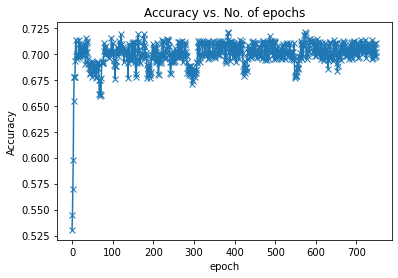

In [ ]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs')

In [ ]:
evaluate(model, test_loader)

{'val_acc': 0.6933808326721191, 'val_loss': 29.978294372558594}

# Conclusion

After trying 5 different Algorithms
we got the results of


*   Logistic Regression : 0.7316215653955097
*   Decision Tree : 0.7258005408951976
*   XGBoost : 0.728458448686969
*   Neural Network (Keras) : 0.6430
*   Neural Network (Pytorch) : 0.6933808326721191

